In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%qtconsole
from IPython.display import display, HTML

# initiate settings

In [2]:
import pandas as pd
import os
import numpy as np
import pylab as plt
from pylab import show
import re
from utils import vector_dist, digitize, rename_labels, \
                  plot_3d_mean_std_pivot_table, plot_3d_pivot_table, plot_4_2d_pt, \
                  plot_4_4_cdfs, plot_moving_window, plot_16_cdfs, rollBy
from scipy.stats import ks_2samp

BASE_DIR = r"D:\Users\Mojo\Google Drive\project - astrophysics\raw_data"
pd.set_option('display.width', 1000)

# import stars and planets table

In [3]:
#### stars table ###
stars_path = os.path.join(BASE_DIR, "stars.xlsx")
stars_raw = pd.read_excel(stars_path)
# clean stars with not Age or Teff
stars_raw = stars_raw[stars_raw.Age.notnull()]
stars_raw = stars_raw[stars_raw.Teff.notnull()]
print "Stars:", stars_raw.shape

### planets table ###
planets_path = os.path.join(BASE_DIR, "planets.xlsx")
planets = pd.read_excel(planets_path)
p_raw = planets
num_rows = p_raw.shape[0]
print "Read {:d} planets from file {:s}".format(num_rows, "planets.xlsx")

Stars: (34886, 12)
Read 4707 planets from file planets.xlsx


###Temperature differences

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BD57358>]], dtype=object)

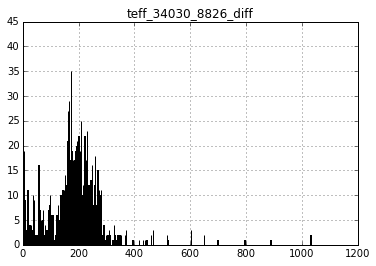

In [4]:
systems_raw = p_raw[['KIC', 'teff_34030_8826_diff']].groupby('KIC').agg(max)
p_raw.hist('teff_34030_8826_diff', bins=500)

# cleanning

In [5]:
def dffilter(df, condition, num_rows, condition_text=""):
    df = df[condition]
    print "Dropped {:d} rows {:s}".format(num_rows - df.shape[0], condition_text)
    num_rows = df.shape[0]
    print "Num rows: {:d}".format(num_rows)
    return df, num_rows

print "Cleaning planets..."
# only deal with planets with age and temperature
p_raw, num_rows = dffilter(p_raw, p_raw.Age.notnull() & p_raw.Teff.notnull(), 
                           num_rows, "without Age or Teff")
# remove those planets with uncertain temperature (temp-diff < 400K)
p_raw, num_rows = dffilter(p_raw, p_raw.teff_34030_8826_diff.fillna(0) < 400,
                           num_rows, "with teff_34030_8826_diff > 400 (undefined temperature)")
# remove planets with wrong period
p_raw, num_rows = dffilter(p_raw, p_raw.koi_period < 5000, 
                           num_rows, "with koi_period > 5000 days")
# remove planets with huge planetary-radius
p_raw, num_rows = dffilter(p_raw, p_raw.koi_prad < 15, 
                           num_rows, "with koi_prad > 15 earth radiii")

Cleaning planets...
Dropped 3383 rows without Age or Teff
Num rows: 1324
Dropped 22 rows with teff_34030_8826_diff > 400 (undefined temperature)
Num rows: 1302
Dropped 1 rows with koi_period > 5000 days
Num rows: 1301
Dropped 53 rows with koi_prad > 15 earth radiii
Num rows: 1248


# Flip Temperature <-> Age (just for fun)

In [6]:
# p_raw = p_raw.rename(columns={'Teff': 'Age', 'Age': 'Teff'})
# stars_raw = stars_raw.rename(columns={'Teff': 'Age', 'Age': 'Teff'})

# filtering - koi_period >< 30

In [7]:
# koi_period and koi_sma (semi major axis) are bascially similar (?)
print "Correlation between koi_period and koi_sma:", p_raw.koi_period.corr(p_raw.koi_sma, method='pearson')

# Filter by Planetary Period
# leave only planets with small period (to be more correct...)
# this is because planets with long period might be "wrong" and not really planets :(
koi_period_threshold = 30
p_raw, num_rows = dffilter(p_raw, p_raw.koi_period < koi_period_threshold, 
                           num_rows, "with koi_period > {:d}".format(koi_period_threshold))

# # Filter by Orbit Semi-major Axis
# koi_sma_threshold = 0.5
# p, num_rows = filter(p, p.koi_sma < koi_sma_threshold, 
#                      num_rows, "with koi_sma > {:d}".format(koi_sma_threshold))

stars = stars_raw
p = p_raw


Correlation between koi_period and koi_sma: 0.970269035778
Dropped 270 rows with koi_period > 30
Num rows: 978


#binning - Only Systems

In [8]:
# create bins according only to systems (and not planets..)
systems = p[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
print "Systems num:", systems.shape[0]
teff_categories, teff_qbins = pd.qcut(systems.Teff.values, 4, retbins=True)
age_categories, age_qbins = pd.qcut(systems.Age.values, 4, retbins=True)

# attach bins to planets-df
p['teff_bins'] = digitize(p.Teff, teff_qbins)
p['age_bins'] = digitize(p.Age, age_qbins)
p['niv'] = 0
systems['teff_bins'] = digitize(systems.Teff, teff_qbins)
systems['age_bins'] = digitize(systems.Age, age_qbins)
systems['niv'] = 0
stars['teff_bins'] = digitize(stars.Teff, bins=teff_qbins)
stars['age_bins'] = digitize(stars.Age, bins=age_qbins)
stars['niv'] = 0

# show nice pivot table for the fresh-created bins
print "Systmes (Host stars):"
pt = systems.pivot_table(index='teff_bins', columns='age_bins', values='niv', aggfunc=len, margins=True)
pt = rename_labels(pt, teff_categories.categories, age_categories.categories)
display(pt)
print "Planets:"
pt = p.pivot_table(index='teff_bins', columns='age_bins', values='niv', aggfunc=len, margins=True)
pt = rename_labels(pt, teff_categories.categories, age_categories.categories)
display(pt)

Systems num: 734
Systmes (Host stars):


Age [Myr],"[0.894, 942.029]","(942.029, 1921.366]","(1921.366, 3249.527]","(3249.527, 11799.886]",All
Teff [K],,,,,
"[3224, 4667]",43,48,46,48,185
"(4667, 5200]",39,41,45,57,182
"(5200, 5618]",42,40,46,56,184
"(5618, 6499]",60,54,46,23,183
All,184,183,183,184,734


Planets:


Age [Myr],"[0.894, 942.029]","(942.029, 1921.366]","(1921.366, 3249.527]","(3249.527, 11799.886]",All
Teff [K],,,,,
"[3224, 4667]",60,69,67,63,259
"(4667, 5200]",52,51,72,74,249
"(5200, 5618]",49,48,56,72,225
"(5618, 6499]",74,70,67,34,245
All,235,238,262,243,978


### frequency (bins mean)

Hosts Systems


Age [Myr],"[0.894, 942.029]","(942.029, 1921.366]","(1921.366, 3249.527]","(3249.527, 11799.886]"
Teff [K],,,,
"[3224, 4667]",43,48,46,48
"(4667, 5200]",39,41,45,57
"(5200, 5618]",42,40,46,56
"(5618, 6499]",60,54,46,23


All stars


Age [Myr],"[0.894, 942.029]","(942.029, 1921.366]","(1921.366, 3249.527]","(3249.527, 11799.886]"
Teff [K],,,,
"[3224, 4667]",2041,1745,1853,2024
"(4667, 5200]",1990,1476,1976,2356
"(5200, 5618]",2587,1871,2398,2086
"(5618, 6499]",5243,2447,1830,963


Frequency


Age [Myr],"[0.894, 942.029]","(942.029, 1921.366]","(1921.366, 3249.527]","(3249.527, 11799.886]",All
Teff [K],,,,,
"[3224, 4667]",0.021068,0.027507,0.024825,0.023715,0.024142
"(4667, 5200]",0.019598,0.027778,0.022773,0.024194,0.023339
"(5200, 5618]",0.016235,0.021379,0.019183,0.026846,0.020577
"(5618, 6499]",0.011444,0.022068,0.025137,0.023884,0.017457
All,0.015513,0.024274,0.022713,0.024768,0.021040


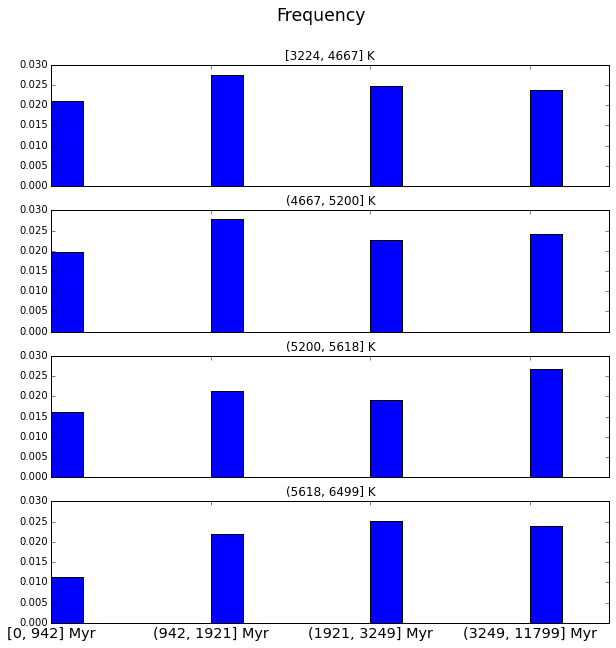

In [9]:
hosts_pt = systems.pivot_table(index='teff_bins', columns='age_bins', values='niv', aggfunc=len)
all_pt = stars.pivot_table(index='teff_bins', columns='age_bins', values='niv', aggfunc=len)
frequency_pt = hosts_pt / all_pt

print "Hosts Systems"
pt = rename_labels(hosts_pt, teff_categories.categories, age_categories.categories)
display(pt)
print "All stars"
pt = rename_labels(all_pt, teff_categories.categories, age_categories.categories)
display(pt)

hosts_pt_margin = systems.pivot_table(index='teff_bins', columns='age_bins', values='niv', aggfunc=len, margins=True)
all_pt_margin = stars.pivot_table(index='teff_bins', columns='age_bins', values='niv', aggfunc=len, margins=True)
frequency_pt_margin = hosts_pt_margin / all_pt_margin
frequency_pt_margin = rename_labels(frequency_pt_margin, teff_categories.categories, age_categories.categories)
print "Frequency"
display(frequency_pt_margin)

frequency_pt = rename_labels(frequency_pt, teff_categories.categories, age_categories.categories)
plot_4_2d_pt(frequency_pt, title="Frequency")

### age-distributions for bins comparison - systems vs. all-planets

KS-scores for teff-bins:
[3224, 4667]K: 0.93
(4667, 5200]K: 0.23
(5200, 5618]K: 0.086
(5618, 6499]K: 1.1e-07


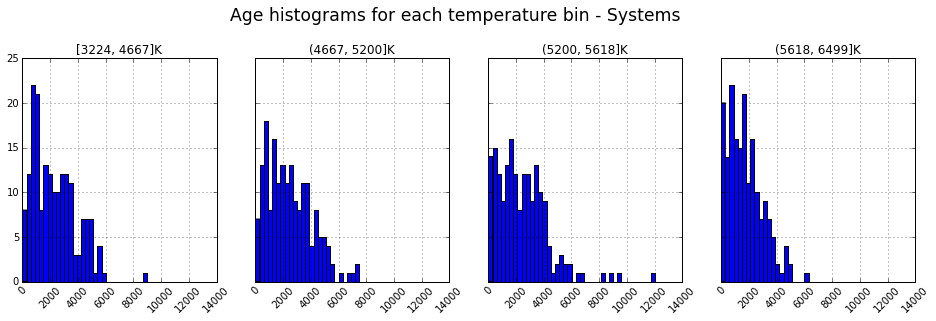

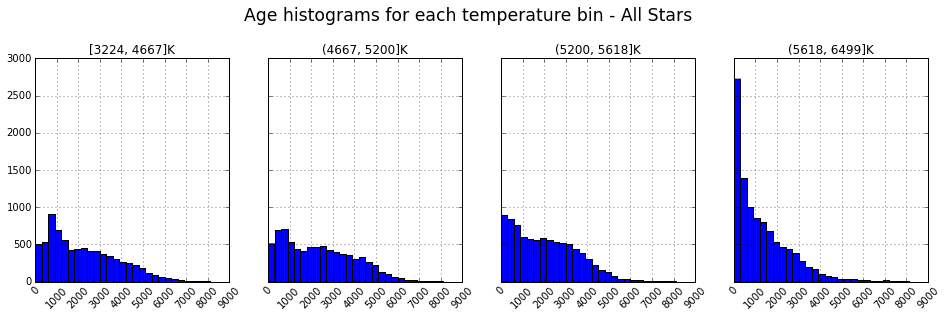

In [10]:
systems['multiplicity'] = p.groupby('KIC').size()
# Create special df just for this cell
systems_mult = systems.copy()


# # print bins' numbers
# multiplicity_pt = systems_mult.pivot_table(index='teff_bins', columns='age_bins', values='niv', aggfunc=len)
# multiplicity_pt = rename_labels(multiplicity_pt, teff_categories.categories, age_categories.categories)
# # print "Number in each bin"
# # display(multiplicity_pt)

binwidth = 200
stars_max_age = 8000

def plot_hists_for_bins(df, title="", binwidth = 300):
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
    fig.suptitle(title, size='xx-large', y=1.08)
    
    for teff_bin in xrange(len(teff_categories.categories)):
        ax = axes[teff_bin]
        s = df[df.teff_bins==teff_bin+1].Age
        s.hist(ax=ax, bins=range(int(s.min()), int(s.max()) + binwidth, binwidth))#, cumulative=True, normed=1)
        ax.set_title("{}K".format(teff_categories.categories[teff_bin]))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
#     plt.locator_params(axis='x', nbins=8)
    # fig.savefig("age_histograms_for_teff_bins.png", bbox_inches='tight')
    

plot_hists_for_bins(systems_mult, title="Age histograms for each temperature bin - Systems")
plot_hists_for_bins(stars[stars.Age < stars_max_age], title="Age histograms for each temperature bin - All Stars")

# calculate KS tests between system-dist to all-stars dist
print "KS-scores for teff-bins:"
for teff_bin in xrange(len(teff_categories.categories)):
    s1 = stars[(stars.teff_bins==teff_bin+1) & (stars.Age < stars_max_age)].Age
    s2 = systems_mult[systems_mult.teff_bins==teff_bin+1].Age
    score = ks_2samp(s1, s2).pvalue
    
    print "{}K: {:.2g}".format(teff_categories.categories[teff_bin], score)
    

### frequency and multiplicity (rolling window statistics)

Frequency moving window - total
1 734
2 689


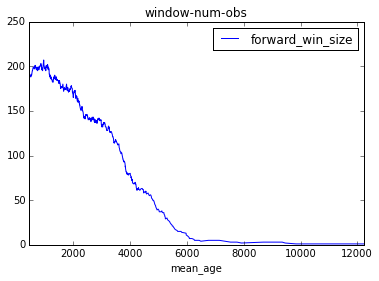

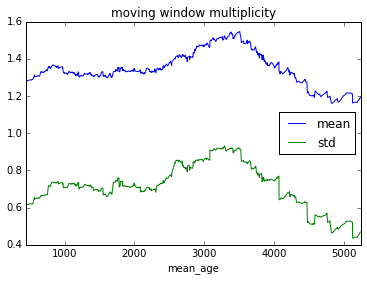

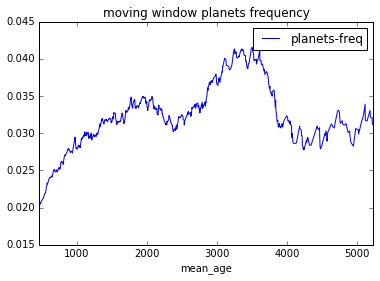

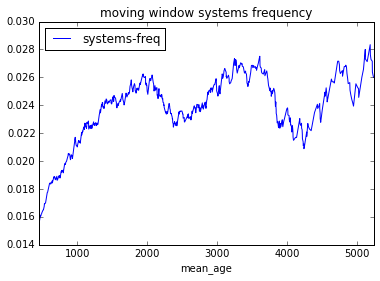

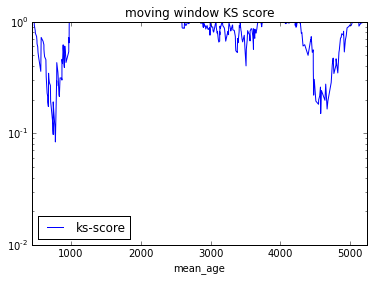

In [11]:
# # filter for only systems with >2 planets
# systems_mult, nrows = dffilter(systems_mult, systems_mult.multiplicity>=1, 
#                                systems_mult.shape[0], "with multiplicity<2")

print "Frequency moving window - total"
q = systems_mult.sort('Age')
rolling_df = rollBy(q.multiplicity, q.Age, stars, window=1000)
rolling_df.plot('mean_age', 'forward_win_size', title="window-num-obs")
print '1', rolling_df.shape[0]
rolling_df = rolling_df[rolling_df.forward_win_size > 30]
print '2', rolling_df.shape[0]
fig = plt.figure()
ax = fig.add_subplot(111)
rolling_df.plot('mean_age', 'mean', title='moving window multiplicity', ax=ax)
rolling_df.plot('mean_age', 'std', ax=ax)
rolling_df.plot('mean_age', 'planets-freq', title='moving window planets frequency')
rolling_df.plot('mean_age', 'systems-freq', title='moving window systems frequency')
rolling_df.plot('mean_age', 'ks-score', title='moving window KS score', logy=True)

trend - rise in planetry multiplicity over time. (X2 from start to somewhere at 3500Myr)

When you look at temperature bins, it starts to be not so significant..

0
1
2
3


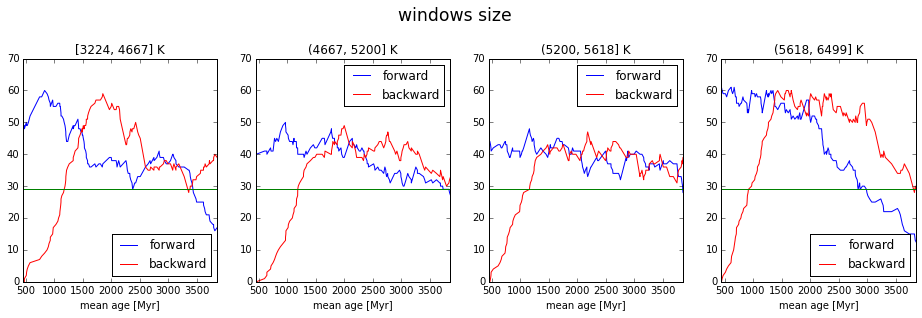

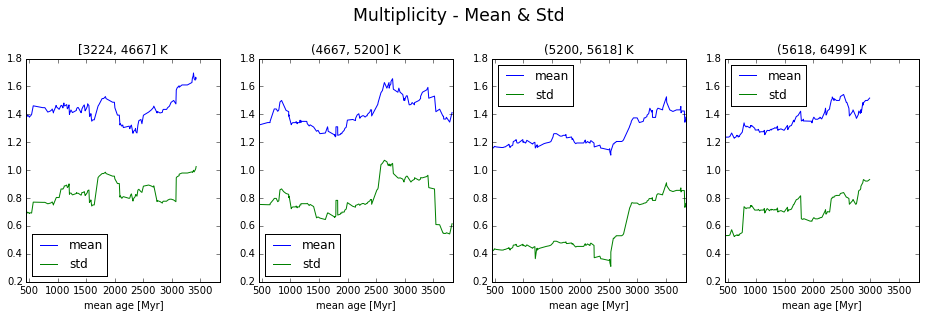

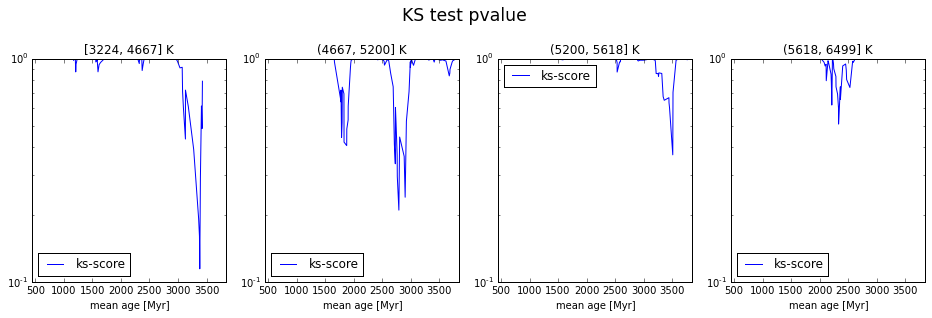

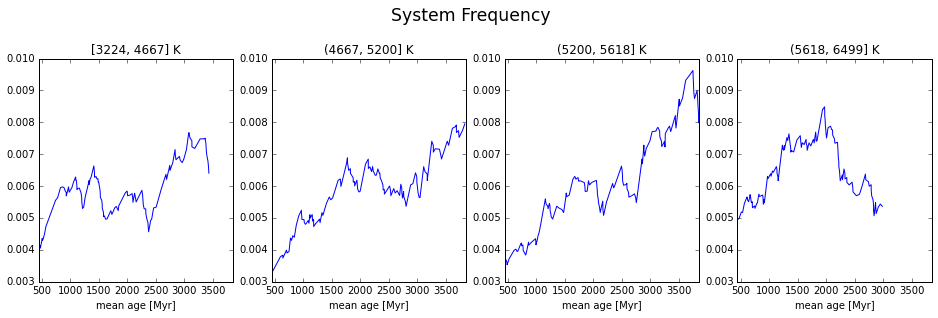

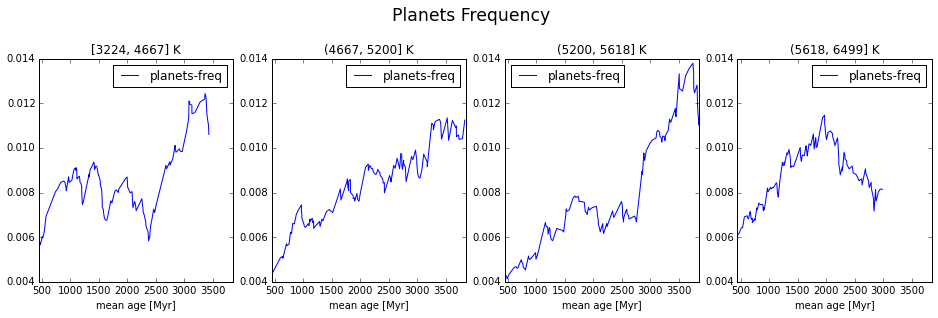

In [12]:
# print multiplicity moving-window 
multiplicity_pt = systems_mult.pivot_table(index='teff_bins', columns='age_bins', values='multiplicity', aggfunc=np.mean)
multiplicity_pt = rename_labels(multiplicity_pt, teff_categories.categories, age_categories.categories)

# display(multiplicity_pt)
plot_moving_window('multiplicity', systems_mult, stars, 
                   teff_categories.categories, age_categories.categories, 
                   age_window_size=1000, window_min_obs=29)

x-axis is the mean-age of the relevant age-window

How do I check if these results are statistically significant?

### Planetary radius

Age [Myr],"[0.894, 942.029]","(942.029, 1921.366]","(1921.366, 3249.527]","(3249.527, 11799.886]"
Teff [K],,,,
"[3224, 4667]",1.533500,1.652580,1.426493,1.725302
"(4667, 5200]",2.554596,2.006667,2.231722,2.208378
"(5200, 5618]",2.552755,2.489958,2.456339,2.369028
"(5618, 6499]",2.678581,2.771267,2.406746,2.474088


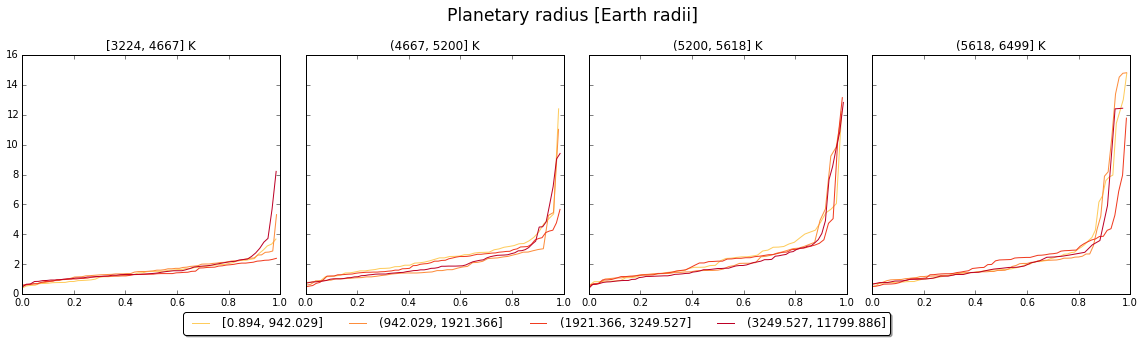

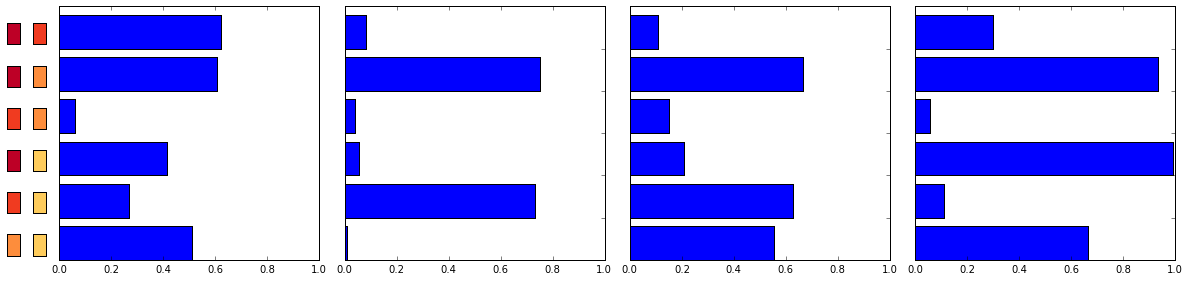

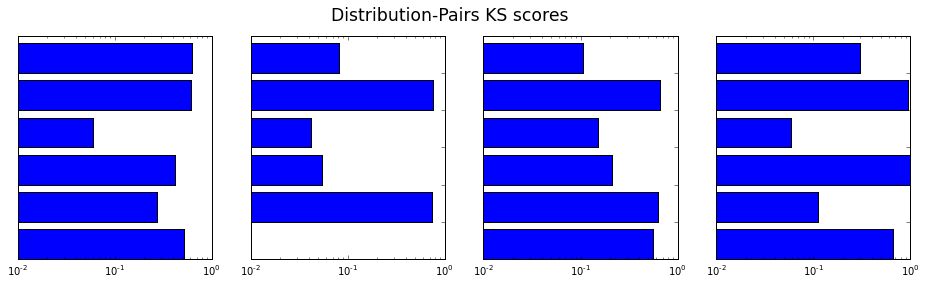

In [13]:
period_pt = p.pivot_table(index='teff_bins', columns='age_bins', values='koi_prad', aggfunc=np.mean)
period_pt = rename_labels(period_pt, teff_categories.categories, age_categories.categories)
display(period_pt)

fig = plot_4_4_cdfs(p, 'koi_prad', teff_categories.categories, age_categories.categories, title='Planetary radius [Earth radii]')
# fig.savefig('radius.png', bbox_inches='tight')

the only one that might be interesting is the second one where the score is very small.

### Planetary Period

Age [Myr],"[0.894, 942.029]","(942.029, 1921.366]","(1921.366, 3249.527]","(3249.527, 11799.886]"
Teff [K],,,,
"[3224, 4667]",8.175626,9.939258,7.597266,7.801624
"(4667, 5200]",8.941006,9.252659,10.823364,8.850670
"(5200, 5618]",7.864041,8.389048,9.911793,9.672416
"(5618, 6499]",8.313903,9.629994,10.611163,9.491084


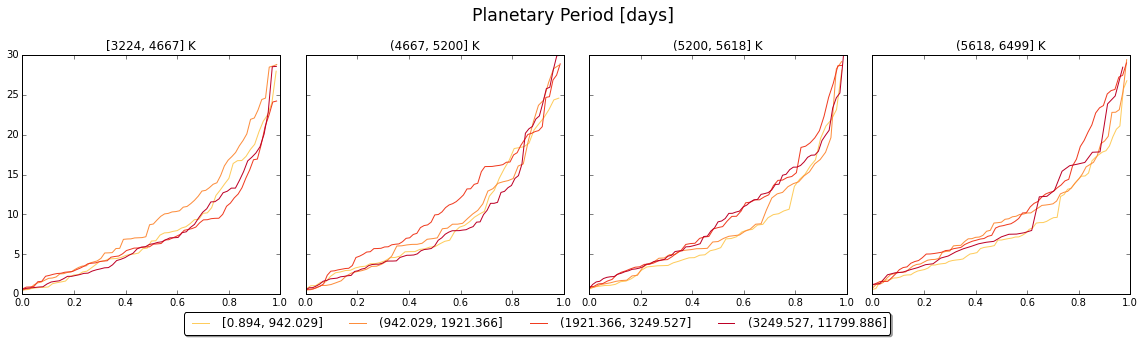

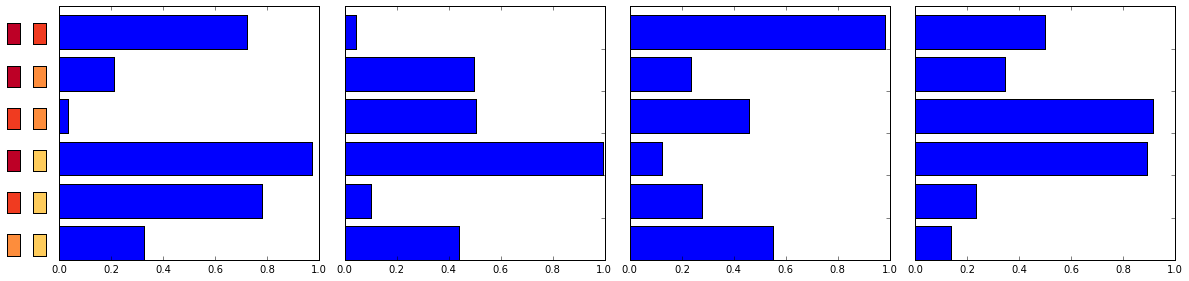

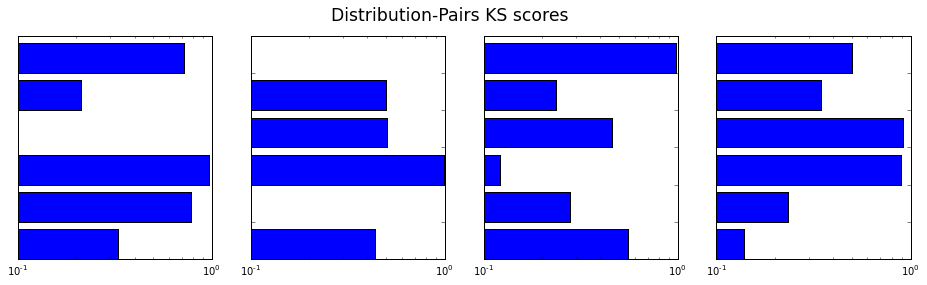

In [14]:
period_pt = p.pivot_table(index='teff_bins', columns='age_bins', values='koi_period', aggfunc=np.mean)
period_pt = rename_labels(period_pt, teff_categories.categories, age_categories.categories)
display(period_pt)

fig = plot_4_4_cdfs(p, 'koi_period', teff_categories.categories, age_categories.categories, title='Planetary Period [days]',
                    figsize=(16, 4))
# fig.savefig('period.png', bbox_inches='tight')

### Period-Radius relation

In [15]:
# fig = plot_radius_vd_period(p, teff_categories.categories, age_categories.categories, title='Period vs. Radius',
#                                    figsize=(10, 10))
# fig.savefig('period.png', bbox_inches='tight')

# comparing - koi_period >< 7

In [16]:
# # Based on the above results, especially the one frequency charts,
# # the main conclusion is that the frequency of planets close to the star increases with age.
# # CHECK WITH HAGAI: That might lead to a model that with time, planets get closer to the star
# # because of angular-momentum transfer to the star. That should only occur with planets close enough to the star.
# # If this is true, we would expect to see a non-increasing frequency with planets farther from the star

# koi_period_threshold = 7
# p_raw, num_rows = dffilter(p_raw, p_raw.koi_period > koi_period_threshold, 
#                            num_rows, "with koi_period > {:d}".format(koi_period_threshold))

# stars = stars_raw
# p = p_raw
# systems = p[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
# print "Systems num:", systems.shape[0]

### bins - swift view

In [17]:
# # attach bins to planets-df
# p['teff_bins'] = digitize(p.Teff, teff_qbins)
# p['age_bins'] = digitize(p.Age, age_qbins)
# systems['teff_bins'] = digitize(systems.Teff, teff_qbins)
# systems['age_bins'] = digitize(systems.Age, age_qbins)
# stars['teff_bins'] = digitize(stars.Teff, bins=teff_qbins)
# stars['age_bins'] = digitize(stars.Age, bins=age_qbins)
# systems['niv'] = 0
# p['niv'] = 0
# stars['niv'] = 0

# # show nice pivot table for the fresh-created bins
# print "Planets:"
# pt = p.pivot_table(index='teff_bins', columns='age_bins', values='niv', aggfunc=len, margins=True)
# pt = rename_labels(pt, teff_categories.categories, age_categories.categories)
# display(pt)
# print "Systmes:"
# pt = systems.pivot_table(index='teff_bins', columns='age_bins', values='niv', aggfunc=len, margins=True)
# pt = rename_labels(pt, teff_categories.categories, age_categories.categories)
# display(pt)

### frequency (rolling window statistics)

In [18]:
# systems['multiplicity'] = p.groupby('KIC').size()
# # Create special df just for this cell
# systems_mult = systems.copy()

# print "Frequency moving window - total"
# # fig = plt.figure(figsize=(10, 10))
# # ax = fig.add_subplot(111)
# q = systems_mult.sort('Age')
# rolling_df = rollBy(q.multiplicity, q.Age, stars, window=1000)
# rolling_df.plot('mean_age', 'forward_win_size', title="window-num-obs")
# print '1', rolling_df.shape[0]
# rolling_df = rolling_df[rolling_df.forward_win_size > 30]
# print '2', rolling_df.shape[0]
# rolling_df.plot('mean_age', 'planets-freq', title='moving window frequency')
# rolling_df.plot('mean_age', 'ks-score', title='moving window KS score', logy=True)

In [19]:
# # print histograms of each bin
# fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
# fig.suptitle("Age histograms for each temperature bin", size='xx-large', y=1.08)
# for teff_bin in xrange(len(teff_categories.categories)):
#     ax = axes[teff_bin]
#     q = systems_mult[systems_mult.teff_bins==teff_bin+1].hist('Age', ax=ax)
#     ax.set_title(teff_categories.categories[teff_bin])
# # fig.savefig("large-period_age_histograms_for_teff_bins.png", bbox_inches='tight')

In [20]:
# # print multiplicity moving-window 
# multiplicity_pt = systems_mult.pivot_table(index='teff_bins', columns='age_bins', values='multiplicity', aggfunc=np.mean)
# multiplicity_pt = rename_labels(multiplicity_pt, teff_categories.categories, age_categories.categories)

# # display(multiplicity_pt)
# plot_moving_window('multiplicity', systems_mult, stars, 
#                    teff_categories.categories, age_categories.categories, 
#                    age_window_size=1000, window_min_obs=5)

So - I can't really see anything special - I mean, it looks pretty decrasing to me as well..

Or if it is not decreasing - How can we really tell?!

In any case - the STATISTICS ARE REALLY SMALL....

what shall we do?